In [1]:
import numpy as np
import matplotlib.pyplot as mplt
from mathphys.functions import save, load
import os
from apsuite.optics_analysis.tune_correction import TuneCorr
from apsuite.orbcorr import OrbRespmat
from pymodels import si
import pyaccel as pa
from siriuspy.clientconfigdb import ConfigDBClient
from siriuspy.search import IDSearch
from siriuspy.devices import VPU, SOFB, IDFF
from siriuspy.search import IDSearch
import GPy as gpy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Get orbit distortions

In [3]:
# Get files
beamline = 'CARNAUBA'

files = os.listdir()
files = sorted(
    [file for file in files if 'orbit_distortions' in file and 'corrs' not in file and beamline in file and 'iter1' in file])
files

['orbit_distortions_VPU_CARNAUBA_iter1.pickle']

In [4]:
devnameivu = IDSearch.conv_beamline_2_idname(beamline=beamline)
vpu = VPU(devnameivu)
idff = IDFF('SI-06SB:BS-IDFF-CC_HARD')
corr_names = list()
corr_names.extend(idff.ccnames)

In [5]:
# Get orbit and gaps from files
orbsx = []
orbsy = []
gaps = []
for file in files:
    data = load(file)
    gaps.append(np.array(data['gap']))
    orbsx.append(data['dorbx'])
    orbsy.append(data['dorby'])

orbsx = np.array(orbsx).reshape((len(files)*len(gaps[0]), 160))
orbsy = np.array(orbsy).reshape((len(files)*len(gaps[0]), 160))
dorb = np.concatenate((orbsx, orbsy), axis=1)

gaps_full = np.array(gaps).reshape((len(files)*len(gaps[0])))
gaps = gaps_full

idcs = np.argsort(gaps)
gaps = gaps[idcs]
dorb = dorb[idcs, :]
nr_pts = len(gaps)


In [6]:
gaps

array([ 9.7, 10. , 11. , 12. , 13. , 14. , 15. , 16. , 17. , 18. , 19. ,
       20. , 30. , 40. , 50. , 60. , 70. , 80. ])

In [6]:
# idcs = gaps <= 22
# gaps = gaps[idcs]
# dorb = dorb[idcs]
# nr_pts = len(gaps)
# dorb = dorb[:, :]-dorb[-1, :]

# Correct distortions

In [8]:
model = si.create_accelerator()
tunecorr = TuneCorr(model=model, acc='SI')
tunecorr.correct_parameters((49.16, 14.22))

1

In [9]:
fam_data = si.get_family_data(model)

### Load local corrs orbit response matrix

In [10]:
files = os.listdir()
files = sorted(
    [file for file in files if 'orbit_distortions_corrs' in file and beamline in file and '5A' in file and 'iter1' in file])
files

['orbit_distortions_corrs_VPU_CARNAUBA_iter1_5A.pickle']

Calc response matrix for each gap

In [11]:
data = load(files[0])
dcurr = data['delta_current']
keys = list(data.keys())
gaps_respm = [float(key.split(' ')[-1]) for key in keys if 'gap' in key]
gaps_respm = np.array(gaps_respm)
idx = np.argsort(gaps_respm)
gaps_respm = gaps_respm[idx]
# idcs = gaps_respm <= 22
# gaps_respm = gaps_respm[idcs]

respmat = np.zeros((len(gaps_respm), 320, 4))
dorb_corrs = np.zeros((len(gaps_respm), 320, 4))
for j, gap in enumerate(gaps_respm):
    for i, corr_name in enumerate(corr_names):
        dorbx = (data['gap {:.2f}'.format(gap)][corr_name]['pos']['dorbx'] - data['gap {:.2f}'.format(gap)][corr_name]['neg']['dorbx'])
        dorby = (data['gap {:.2f}'.format(gap)][corr_name]['pos']['dorby'] - data['gap {:.2f}'.format(gap)][corr_name]['neg']['dorby'])
        dorb_ = np.hstack((dorbx, dorby))
        dorb_corrs[j, :, i] = dorb_
        respmat[j, :, i] = dorb_/dcurr


check if there are different gaps from correctors and ID orbit distortion measurements

In [12]:
gaps_respm_full = np.full((len(gaps), len(gaps_respm)), gaps_respm)
idcs = np.where((gaps_respm_full.T - gaps) == 0)[1]
gaps = gaps[idcs]

In [13]:
gaps_respm

array([ 9.7, 10. , 11. , 12. , 13. , 14. , 15. , 16. , 17. , 18. , 19. ,
       20. , 30. , 40. , 50. , 60. , 70. , 80. ])

In [14]:
dorb = dorb[idcs, :]

In [17]:
respmat.shape

(12, 320, 4)

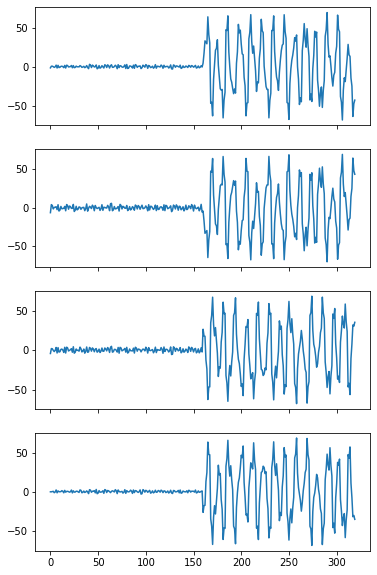

In [15]:
gap_idx = 2
fig, ax = mplt.subplots(4,1, sharex=True, figsize=(6,10))
ax[0].plot(respmat[gap_idx, :, 0])
ax[1].plot(respmat[gap_idx, :, 1])
ax[2].plot(respmat[gap_idx, :, 2])
ax[3].plot(respmat[gap_idx, :, 3])

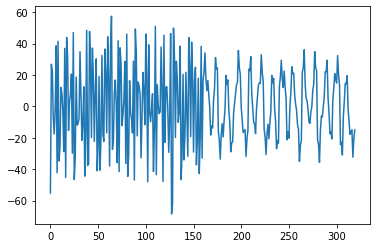

In [16]:
mplt.plot(dorb[0, :])

### Perform correction

In [17]:
# load sofb respmat
sofb_respmat = np.array(ConfigDBClient(config_type='si_orbcorr_respm').get_config_value('ref_respmat'))

In [18]:
# Apply filter
# Correct orbit with SOFB
kick_s = np.linalg.pinv(sofb_respmat) @ dorb.T

# Keep only the kicks from the 4 SOFB corrs. closest to the ID
# Select corrector closest to the ID

nr_corrs = 4

fam_data = si.get_family_data(model)
if beamline == 'CARNAUBA':
    vpu_idc = fam_data['VPU29']['index'][0]
vpu_idc = int(np.array(vpu_idc).mean())

idcs_allch = fam_data['CH']['index']
idcs_allcv = fam_data['CV']['index']
idcs_allch = np.array(idcs_allch).reshape(len(idcs_allch))
idcs_allcv = np.array(idcs_allcv).reshape(len(idcs_allcv))

idcsclosest_ch = np.sort(np.argsort(np.abs(idcs_allch - vpu_idc), axis=0)[:nr_corrs])
idcsclosest_cv = np.sort(np.argsort(np.abs(idcs_allcv - vpu_idc), axis=0)[:nr_corrs])

idcs_corrsch_model = idcs_allch[idcsclosest_ch]
idcs_corrscv_model = idcs_allcv[idcsclosest_cv]

mask = np.zeros(len(kick_s))
mask[idcsclosest_ch] = 1
mask[len(idcs_allch)+idcsclosest_cv] = 1
mask = np.full((len(gaps), mask.shape[0]), mask)
mask = np.swapaxes(mask, 0, 1)

kick_s *= mask

# Calculate the Filtered Orbit Distortion (local, ID distortion)
orb_dist_f = (sofb_respmat @ kick_s).T
# orb_dist_f = dorb

### these lines balances the field strength between components x,y
# orb_dist_f[:, 0:160] *= 0
# orb_dist_f[:, 160:] *= 0.55



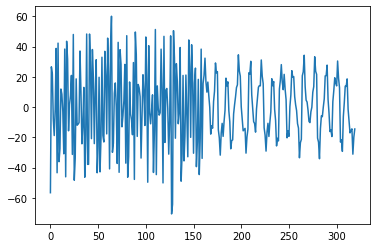

In [19]:
mplt.plot(orb_dist_f[0, :])

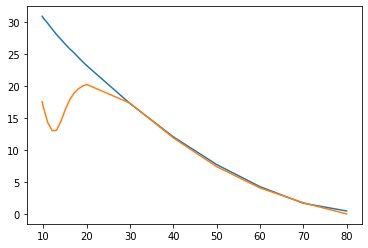

In [20]:
dorbx_rms = np.std(orb_dist_f[:, 0:160], axis=1)
dorby_rms = np.std(orb_dist_f[:, 160:], axis=1)
mplt.plot(gaps, dorbx_rms)
mplt.plot(gaps, dorby_rms)

check singular values and degenerescencia

In [23]:
corr_kicks = np.zeros((len(gaps_respm), 4))
for i, gap in enumerate(gaps_respm):
    u, s, vt = np.linalg.svd(respmat[i, :, :], full_matrices=False)
    print(s)
    ismat = 1/s
    idcs = s < 2
    ismat[idcs] = 0
    ismat = np.diag(ismat)
    invmat = np.dot(np.dot(vt.T, ismat), u.T)
    corr_kicks[i, :] = (invmat @ orb_dist_f[i, :].T)

[822.20910548 323.31222242  42.80548369  13.36667666]
[820.95030748 322.99299551  42.01850947  13.33570728]
[843.54240415 331.49977537  42.83914875  13.50282461]
[827.91548639 325.82656613  42.10668035  13.64227768]
[838.39509945 329.93599279  42.82891334  13.61763301]
[854.61887896 336.63570539  45.26729129  14.79630491]
[852.04217399 335.31759694  46.7048645   15.30987947]
[852.78007942 335.02441793  49.76592826  16.30218907]
[844.91592997 331.83799729  52.30382173  17.68802404]
[839.47285267 329.78653688  56.3336898   18.7948705 ]
[832.99046671 327.28851744  59.56690337  20.64732008]
[821.30817301 322.10069358  62.92536518  21.80356958]
[729.55613682 286.62461607  92.63090561  33.78490313]
[660.87238691 259.71583855 103.1900556   38.697939  ]
[600.27685439 236.35289357  97.76333661  37.18989306]
[558.26975323 219.89837127  85.06887721  32.68767455]
[524.0861773  206.90131832  67.97590934  26.96126638]
[486.2008024  191.59213936  48.02938125  19.72136846]


In [31]:
#### not the most generic method
#### Calculate the ID correctors kicks to correct the local distortions
# corr_kicks = np.zeros((len(gaps_respm), 4))
# for i, gap in enumerate(gaps_respm):
#     corr_kicks[i, :] = (np.linalg.pinv(respmat[i, :, :]) @ orb_dist_f[i, :].T)

In [24]:
# If measured local corrs respmat was used
corr_currents = corr_kicks.T

In [25]:
corr_currents.max()

5.027456938960582

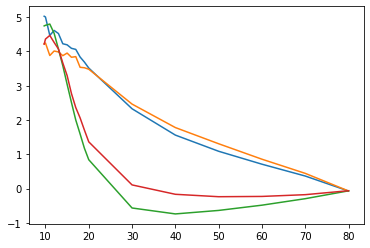

In [26]:
mplt.plot(gaps, corr_currents[0, :], '-')
mplt.plot(gaps, corr_currents[1, :], '-')
mplt.plot(gaps, corr_currents[2, :], '-')
mplt.plot(gaps, corr_currents[3, :], '-')

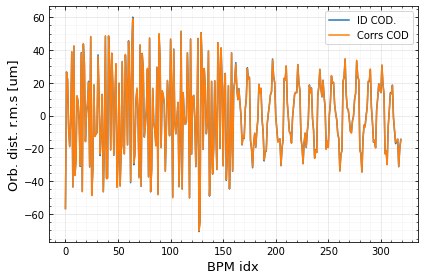

In [27]:

dorb_fit = respmat[0,:, :] @ corr_kicks[0, :]

mplt.figure()
mplt.plot(orb_dist_f[0, :], label='ID COD.')
mplt.plot(dorb_fit, label='Corrs COD')
mplt.minorticks_on()
mplt.grid(which="major", alpha=0.3)
mplt.grid(which="minor", alpha=0.1)
mplt.tick_params(
            which="both", axis="both", direction="in", right=True, top=True
)
# mplt.ylim(-35, 35)
mplt.legend()
mplt.ylabel('Orb. dist. r.m.s [um]', fontsize=13)
mplt.xlabel('BPM idx', fontsize=13)
mplt.tight_layout()
mplt.savefig('partial_correction.png', dpi=300)

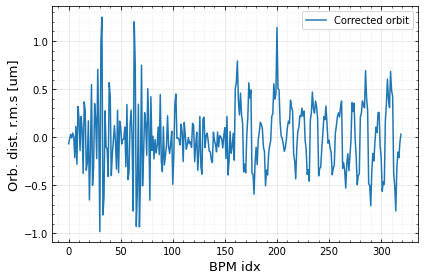

In [28]:

dorb_fit = respmat[0,:, :] @ corr_kicks[0, :]

mplt.figure()
mplt.plot(orb_dist_f[0, :]-dorb_fit, label='Corrected orbit')
mplt.minorticks_on()
mplt.grid(which="major", alpha=0.3)
mplt.grid(which="minor", alpha=0.1)
mplt.tick_params(
            which="both", axis="both", direction="in", right=True, top=True
)
# mplt.ylim(-35, 35)
mplt.legend()
mplt.ylabel('Orb. dist. r.m.s [um]', fontsize=13)
mplt.xlabel('BPM idx', fontsize=13)
mplt.tight_layout()
mplt.savefig('partial_correction_residue.png', dpi=300)

# Gaussian process

In [30]:
corr_currents[0, -1]

-0.06987794033750655

In [31]:
corr_currents[0, -1] = 0
corr_currents[1, -1] = 0
corr_currents[2, -1] = 0
corr_currents[3, -1] = 0

5.027456938960582


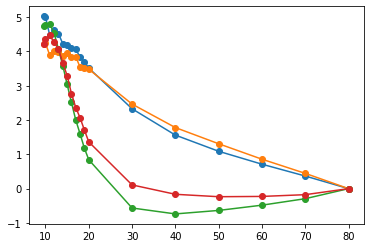

In [32]:
# mplt.figure()
mplt.plot(gaps, corr_currents[0, :], '-o')
mplt.plot(gaps, corr_currents[1, :], '-o')
mplt.plot(gaps, corr_currents[2, :], '-o')
mplt.plot(gaps, corr_currents[3, :], '-o')

print(np.max(corr_currents[0, :]))

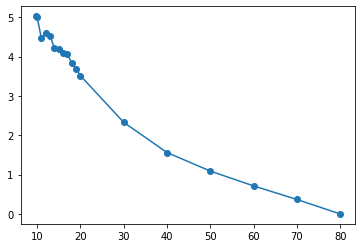

In [33]:
mplt.plot(gaps, corr_currents[0, :], '-o')

In [34]:
# Gaussian process
ker = gpy.kern.RBF(input_dim=1)
ch1_kicks = corr_currents[0, :]
ch2_kicks = corr_currents[1, :]
cv1_kicks = corr_currents[2, :]
cv2_kicks = corr_currents[3, :]

X = np.vstack([gaps])
Y = np.vstack((ch1_kicks, ch2_kicks, cv1_kicks, cv2_kicks))
model = gpy.models.GPRegression(X.T,  Y.T,  ker)

model.optimize_restarts(num_restarts=10, num_processes=6, verbose=True)

gaps_full = np.linspace(0, 80, 1000)
X = np.vstack([gaps_full])
y_pred, var = model.predict(X.T)

Optimization restart 1/10, f = 39.115445711318365
Optimization restart 2/10, f = 39.115445711420115
Optimization restart 3/10, f = 39.1154457113193
Optimization restart 4/10, f = 37.81704379377078
Optimization restart 5/10, f = 37.81704379376613
Optimization restart 6/10, f = 39.11544571136875
Optimization restart 7/10, f = 39.11544571134991
Optimization restart 8/10, f = 39.115445711321115
Optimization restart 9/10, f = 37.81704379376692
Optimization restart 10/10, f = 37.81704379377575


In [35]:
%matplotlib qt5
mplt.plot(gaps, corr_currents[0, :], 'o')
mplt.plot(gaps, corr_currents[1, :], 'o')
mplt.plot(gaps, corr_currents[2, :], 'o')
mplt.plot(gaps, corr_currents[3, :], 'o')

mplt.plot(gaps_full, y_pred[:, 0], '--', color='C0')
mplt.plot(gaps_full, y_pred[:, 1], '--', color='C1')
mplt.plot(gaps_full, y_pred[:, 2], '--', color='C2')
mplt.plot(gaps_full, y_pred[:, 3], '--', color='C3')
mplt.show()

# Format Table

In [36]:
clt = ConfigDBClient(config_type='si_idff')
clt.find_configs()

[{'config_type': 'si_idff',
  'created': 1676469132.2352946,
  'discarded': False,
  'modified': [1676469132.2352946],
  'name': 'wig180_ref'},
 {'config_type': 'si_idff',
  'created': 1676473856.608427,
  'discarded': False,
  'modified': [1676473856.608427],
  'name': 'epu50_2023-02-15'},
 {'config_type': 'si_idff',
  'created': 1676487170.3492222,
  'discarded': False,
  'modified': [1676487170.3492222],
  'name': 'epu50_2023-01-23'},
 {'config_type': 'si_idff',
  'created': 1682540087.3466027,
  'discarded': False,
  'modified': [1682540087.3466027],
  'name': 'epu50_2023-04-18'},
 {'config_type': 'si_idff',
  'created': 1683048629.7169259,
  'discarded': False,
  'modified': [1683048629.7169259],
  'name': 'epu50_2023-05-02'},
 {'config_type': 'si_idff',
  'created': 1683218561.2117841,
  'discarded': False,
  'modified': [1683218561.2117841],
  'name': 'epu50_2023-05-04-tests'},
 {'config_type': 'si_idff',
  'created': 1685580127.9767976,
  'discarded': False,
  'modified': [1685

In [37]:
clt = ConfigDBClient(config_type='si_idff')
config = clt.get_config_value('si_06sb_vpu29_ref')
config

{'description': 'Feedforward table VPU CNB. Measured on 2025/06/16.',
 'offsets': {'qd1_1': 0,
  'qd1_2': 0,
  'qd2_1': 0,
  'qd2_2': 0,
  'qf_1': 0,
  'qf_2': 0},
 'polarizations': {'vertical': {'cc1_1': [-5.576898456887994,
    -5.5763806149100885,
    -5.5757786098469815,
    -5.575092515641574,
    -5.5743224106098594,
    -5.573468377436106,
    -5.57253050316785,
    -5.57150887921039,
    -5.57040360132095,
    -5.569214769602466,
    -5.567942488496993,
    -5.566586866778697,
    -5.5651480175465355,
    -5.563626058216459,
    -5.56202111051335,
    -5.560333300462506,
    -5.558562758380756,
    -5.556709618867218,
    -5.554774020793703,
    -5.552756107294669,
    -5.550656025756863,
    -5.548473927808586,
    -5.546209969308576,
    -5.5438643103344765,
    -5.5414371151710204,
    -5.53892855229772,
    -5.536338794376386,
    -5.533668018238026,
    -5.5309164048695685,
    -5.52808413940018,
    -5.5251714110871015,
    -5.522178413301311,
    -5.5191053435127,
    -5

In [43]:
corr_names

['SI-06SB:PS-CC1-1',
 'SI-06SB:PS-CC2-1',
 'SI-06SB:PS-CC2-2',
 'SI-06SB:PS-CC1-2']

In [38]:
config['description'] = 'Feedforward table VPU CNB. 2nd Measurement on 2025/06/16.'
config['polarizations']['vertical']['cc1_1'] = (-1*y_pred[:, 0]).tolist()
config['polarizations']['vertical']['cc2_1'] = (-1*y_pred[:, 1]).tolist()
config['polarizations']['vertical']['cc2_2'] = (-1*y_pred[:, 2]).tolist()
config['polarizations']['vertical']['cc1_2'] = (-1*y_pred[:, 3]).tolist()
config['polarizations']['vertical']['kparameter'] = gaps_full.tolist()

In [39]:
clt.check_valid_value(config)
clt.insert_config('si_06sb_vpu29_dev', config)